In [9]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from statsmodels.tsa.statespace.sarimax import SARIMAX
import plotly.graph_objects as go
from plotly.subplots import make_subplots


In [8]:
file_path = 'MarketPricePrediction.csv'
df = pd.read_csv(file_path)

# Preprocessing the data
df.dropna(inplace=True)
df_encoded = pd.get_dummies(df, columns=['market', 'month', 'state', 'city'])

# Convert 'date' column to datetime and set as index
df_encoded['date'] = pd.to_datetime(df_encoded['date'], format='%B-%Y')
df_encoded.set_index('date', inplace=True)
df_encoded.sort_index(ascending=True, inplace=True)

# Scaling the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_encoded)

# Prepare the data for LSTM
def create_dataset(dataset, time_step=1):
    dataX, dataY_quantity, dataY_prices = [], [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), :]
        dataX.append(a)
        dataY_quantity.append(dataset[i + time_step, 1])  # Assuming 'quantity' is the 2nd column
        dataY_prices.append(dataset[i + time_step, 2:4])  # Assuming 'priceMin' and 'priceMax' are the 3rd and 4th columns
    return np.array(dataX), np.array(dataY_quantity), np.array(dataY_prices)

time_step = 12
X, y_quantity, y_prices = create_dataset(scaled_data, time_step)

# Split the data into training and test sets
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_quantity_train, y_quantity_test = y_quantity[0:train_size], y_quantity[train_size:len(y_quantity)]
y_prices_train, y_prices_test = y_prices[0:train_size], y_prices[train_size:len(y_prices)]


In [12]:
fig = make_subplots(rows=4, cols=1, shared_xaxes=True, 
                    subplot_titles=('Quantity over Time', 'Minimum Price over Time', 'Maximum Price over Time', 'Mode Price over Time'))
# Add traces
fig.add_trace(go.Scatter(x=df.index, y=df['quantity'], mode='lines', name='Quantity', line=dict(color='blue')), row=1, col=1)
fig.add_trace(go.Scatter(x=df.index, y=df['priceMin'], mode='lines', name='Minimum Price', line=dict(color='green')), row=2, col=1)
fig.add_trace(go.Scatter(x=df.index, y=df['priceMax'], mode='lines', name='Maximum Price', line=dict(color='red')), row=3, col=1)
fig.add_trace(go.Scatter(x=df.index, y=df['priceMod'], mode='lines', name='Mode Price', line=dict(color='purple')), row=4, col=1)

# Update layout
fig.update_layout(height=1600, width=1000, title_text='Time Series Analysis', showlegend=False)
fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Quantity', row=1, col=1)
fig.update_yaxes(title_text='PriceMin', row=2, col=1)
fig.update_yaxes(title_text='PriceMax', row=3, col=1)
fig.update_yaxes(title_text='PriceMod', row=4, col=1)

# Show the figure
fig.show()

ARIMA Quantity Metrics: MSE: 27864794831.035, MAE: 81499.624, RMSE: 166927.514
ARIMA PriceMin Metrics: MSE: 1911978.246, MAE: 1100.303, RMSE: 1382.743
ARIMA PriceMax Metrics: MSE: 5315439.892, MAE: 2057.992, RMSE: 2305.524


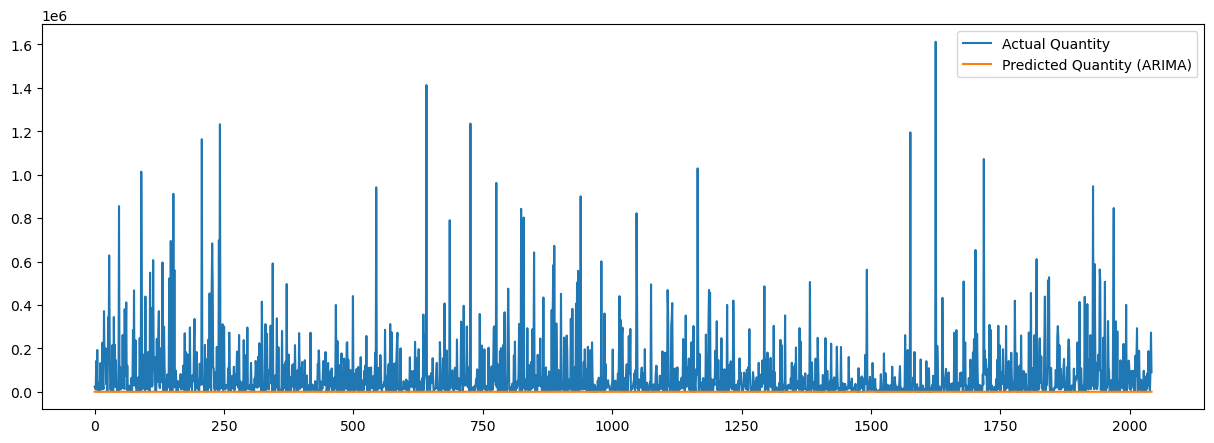

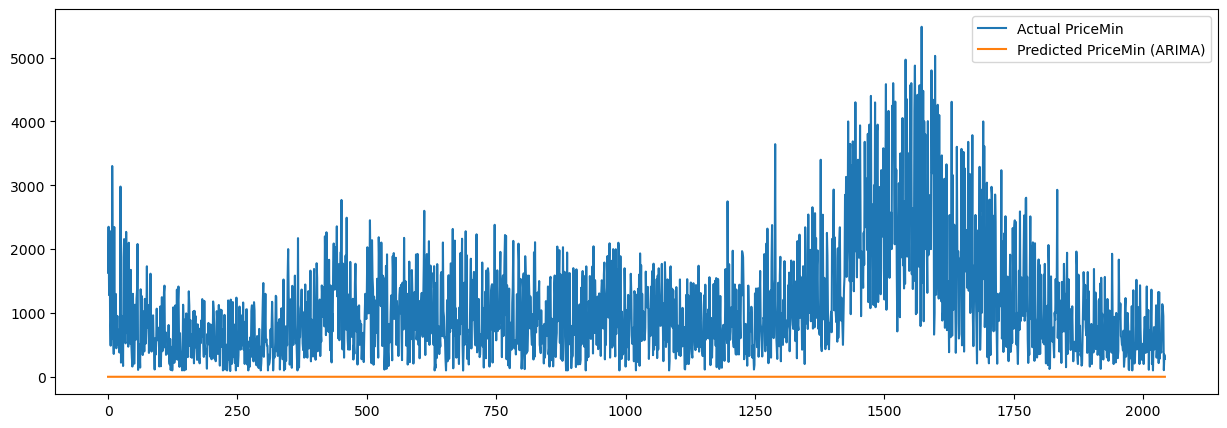

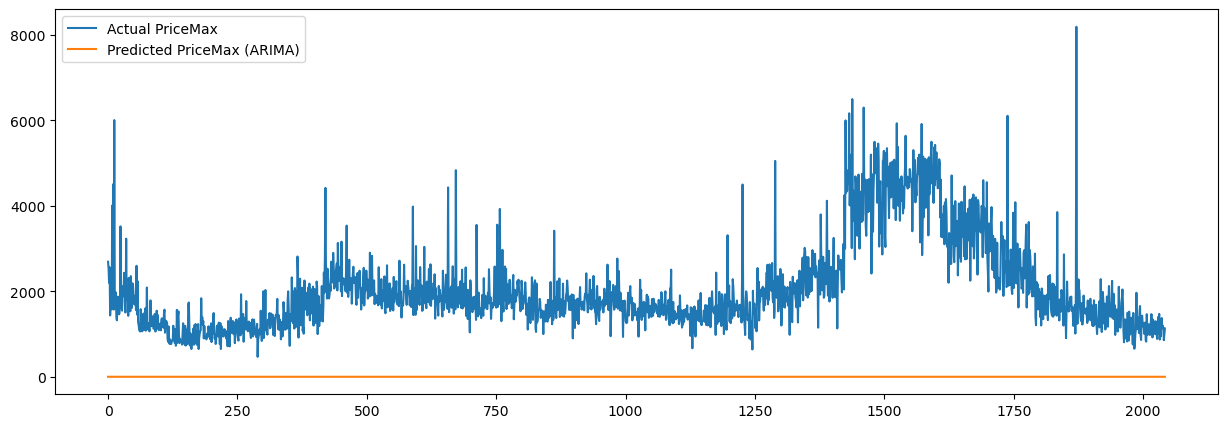

In [3]:


# Train ARIMA for quantity
best_arima_order_quantity = (2, 1, 2)
arima_model_quantity = ARIMA(y_quantity_train, order=best_arima_order_quantity).fit()
arima_predictions_quantity = arima_model_quantity.forecast(steps=len(y_quantity_test))

# Train ARIMA for priceMin
best_arima_order_prices = (1, 1, 1)
arima_model_priceMin = ARIMA(y_prices_train[:, 0], order=best_arima_order_prices).fit()
arima_predictions_priceMin = arima_model_priceMin.forecast(steps=len(y_prices_test))

# Train ARIMA for priceMax
arima_model_priceMax = ARIMA(y_prices_train[:, 1], order=best_arima_order_prices).fit()
arima_predictions_priceMax = arima_model_priceMax.forecast(steps=len(y_prices_test))

# Metrics calculation
def calculate_metrics(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mse)
    return mse, mae, rmse

# Inverse transform actual values
actual_quantity = scaler.inverse_transform(np.concatenate((np.zeros((y_quantity_test.shape[0], 1)), y_quantity_test.reshape(-1, 1), np.zeros((y_quantity_test.shape[0], scaled_data.shape[1] - 2))), axis=1))[:, 1]
actual_prices = scaler.inverse_transform(np.concatenate((np.zeros((y_prices_test.shape[0], 2)), y_prices_test, np.zeros((y_prices_test.shape[0], scaled_data.shape[1] - 4))), axis=1))[:, 2:4]

# Calculate metrics for ARIMA
arima_metrics_quantity = calculate_metrics(actual_quantity, arima_predictions_quantity)
arima_metrics_priceMin = calculate_metrics(actual_prices[:, 0], arima_predictions_priceMin)
arima_metrics_priceMax = calculate_metrics(actual_prices[:, 1], arima_predictions_priceMax)

# Print the metrics
print('ARIMA Quantity Metrics: MSE: {:.3f}, MAE: {:.3f}, RMSE: {:.3f}'.format(*arima_metrics_quantity))
print('ARIMA PriceMin Metrics: MSE: {:.3f}, MAE: {:.3f}, RMSE: {:.3f}'.format(*arima_metrics_priceMin))
print('ARIMA PriceMax Metrics: MSE: {:.3f}, MAE: {:.3f}, RMSE: {:.3f}'.format(*arima_metrics_priceMax))

# Plot ARIMA predictions vs actual
plt.figure(figsize=(15, 5))
plt.plot(actual_quantity, label='Actual Quantity')
plt.plot(arima_predictions_quantity, label='Predicted Quantity (ARIMA)')
plt.legend()
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(actual_prices[:, 0], label='Actual PriceMin')
plt.plot(arima_predictions_priceMin, label='Predicted PriceMin (ARIMA)')
plt.legend()
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(actual_prices[:, 1], label='Actual PriceMax')
plt.plot(arima_predictions_priceMax, label='Predicted PriceMax (ARIMA)')
plt.legend()
plt.show()


C:\Users\USER\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\USER\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\USER\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\USER\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\USER\anaconda3\Lib\site-packages\statsmodels\base\model.py:6

SARIMA Quantity Metrics: MSE: 27864795163.893, MAE: 81499.626, RMSE: 166927.515
SARIMA PriceMin Metrics: MSE: 1913659.167, MAE: 1100.978, RMSE: 1383.351
SARIMA PriceMax Metrics: MSE: 5315021.794, MAE: 2057.900, RMSE: 2305.433


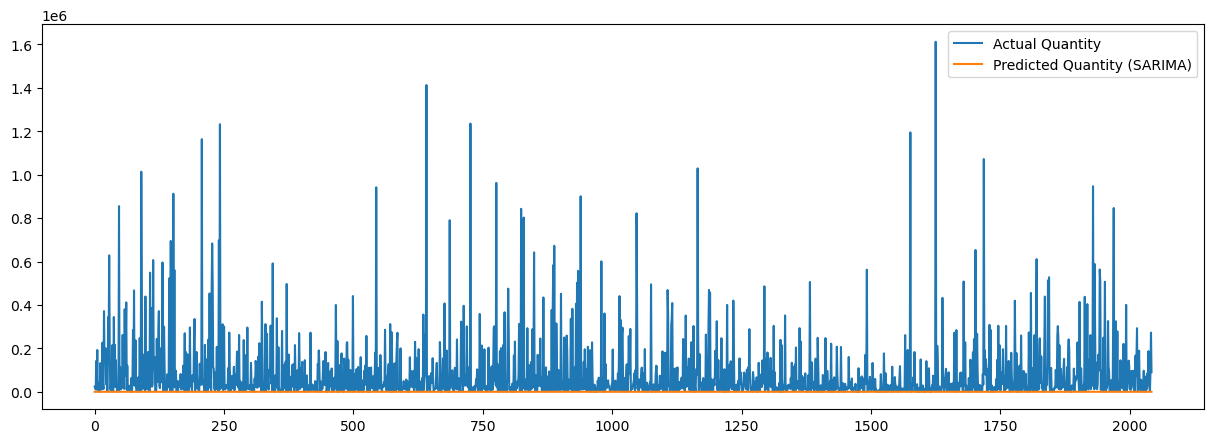

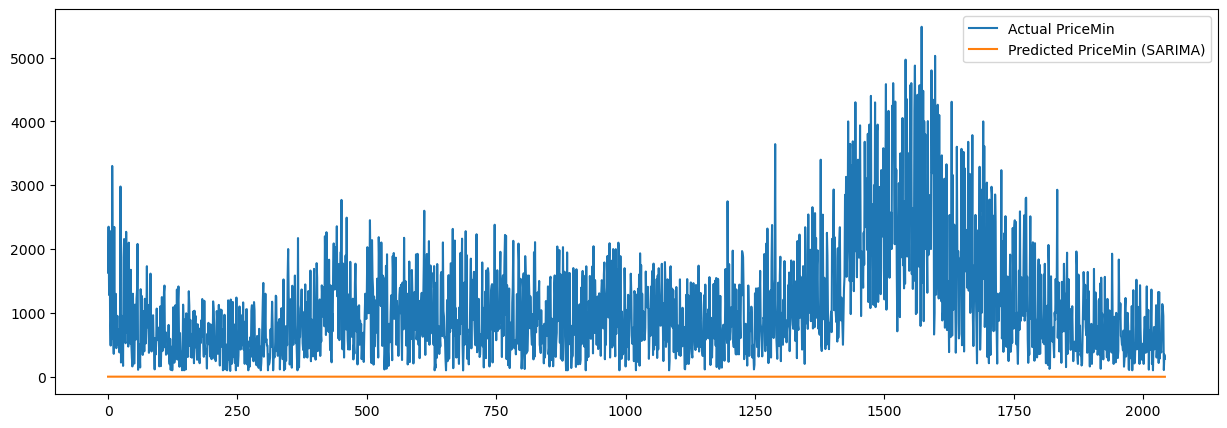

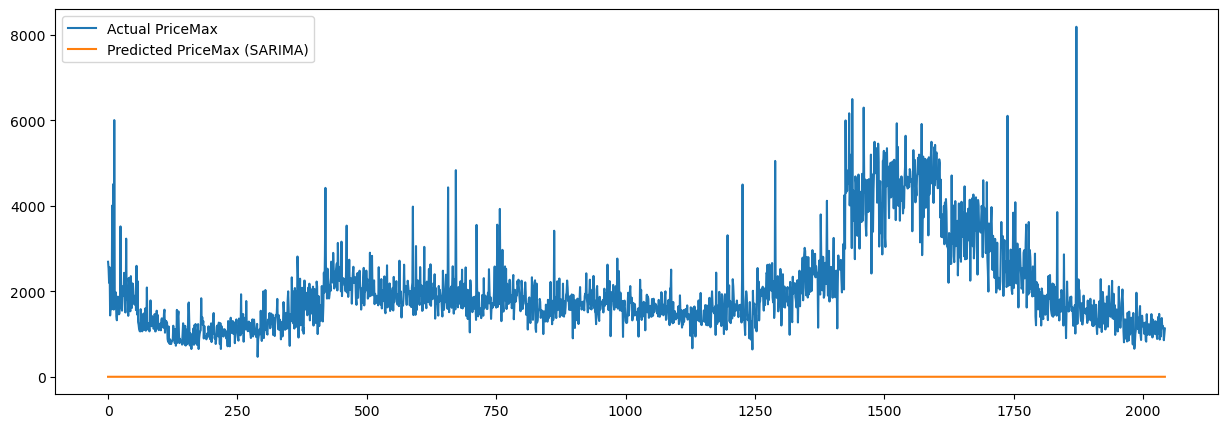

In [6]:

# Train SARIMA for quantity
best_sarima_order_quantity = (2, 1, 2)
best_sarima_seasonal_order_quantity = (1, 1, 1, 12)
sarima_model_quantity = SARIMAX(y_quantity_train, order=best_sarima_order_quantity, seasonal_order=best_sarima_seasonal_order_quantity).fit()
sarima_predictions_quantity = sarima_model_quantity.forecast(steps=len(y_quantity_test))

# Train SARIMA for priceMin
best_sarima_order_prices = (2, 2, 4)
best_sarima_seasonal_order_prices = (1, 1, 1, 12)
sarima_model_priceMin = SARIMAX(y_prices_train[:, 0], order=best_sarima_order_prices, seasonal_order=best_sarima_seasonal_order_prices).fit()
sarima_predictions_priceMin = sarima_model_priceMin.forecast(steps=len(y_prices_test))

# Train SARIMA for priceMax
sarima_model_priceMax = SARIMAX(y_prices_train[:, 1], order=best_sarima_order_prices, seasonal_order=best_sarima_seasonal_order_prices).fit()
sarima_predictions_priceMax = sarima_model_priceMax.forecast(steps=len(y_prices_test))

# Calculate metrics for SARIMA
sarima_metrics_quantity = calculate_metrics(actual_quantity, sarima_predictions_quantity)
sarima_metrics_priceMin = calculate_metrics(actual_prices[:, 0], sarima_predictions_priceMin)
sarima_metrics_priceMax = calculate_metrics(actual_prices[:, 1], sarima_predictions_priceMax)

# Print the metrics
print('SARIMA Quantity Metrics: MSE: {:.3f}, MAE: {:.3f}, RMSE: {:.3f}'.format(*sarima_metrics_quantity))
print('SARIMA PriceMin Metrics: MSE: {:.3f}, MAE: {:.3f}, RMSE: {:.3f}'.format(*sarima_metrics_priceMin))
print('SARIMA PriceMax Metrics: MSE: {:.3f}, MAE: {:.3f}, RMSE: {:.3f}'.format(*sarima_metrics_priceMax))

# Plot SARIMA predictions vs actual
plt.figure(figsize=(15, 5))
plt.plot(actual_quantity, label='Actual Quantity')
plt.plot(sarima_predictions_quantity, label='Predicted Quantity (SARIMA)')
plt.legend()
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(actual_prices[:, 0], label='Actual PriceMin')
plt.plot(sarima_predictions_priceMin, label='Predicted PriceMin (SARIMA)')
plt.legend()
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(actual_prices[:, 1], label='Actual PriceMax')
plt.plot(sarima_predictions_priceMax, label='Predicted PriceMax (SARIMA)')
plt.legend()
plt.show()




Epoch 1/50

256/256 [==============================] - 14s 27ms/step - loss: 0.0046
Epoch 2/50
256/256 [==============================] - 7s 27ms/step - loss: 0.0039
Epoch 3/50
256/256 [==============================] - 7s 27ms/step - loss: 0.0039
Epoch 4/50
256/256 [==============================] - 9s 34ms/step - loss: 0.0038
Epoch 5/50
256/256 [==============================] - 7s 29ms/step - loss: 0.0038
Epoch 6/50
256/256 [==============================] - 8s 31ms/step - loss: 0.0037
Epoch 7/50
256/256 [==============================] - 10s 38ms/step - loss: 0.0037
Epoch 8/50
256/256 [==============================] - 10s 39ms/step - loss: 0.0037
Epoch 9/50
256/256 [==============================] - 10s 39ms/step - loss: 0.0037
Epoch 10/50
256/256 [==============================] - 9s 34ms/step - loss: 0.0037
Epoch 11/50
256/256 [==============================] - 8s 31ms/step - loss: 0.0036
Epoch 12/50
256/256 [==============================] - 9s 34ms/step - loss: 0.0036
Epoch 

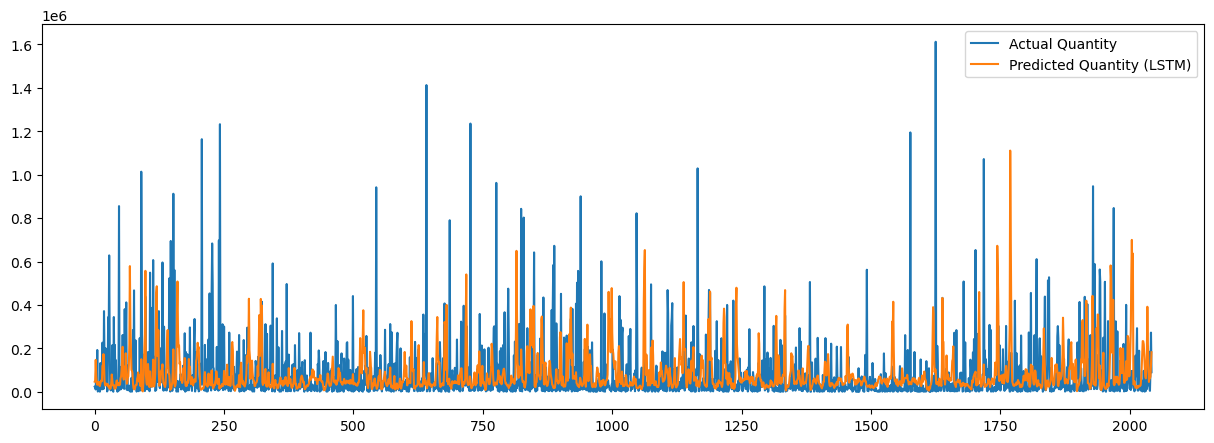

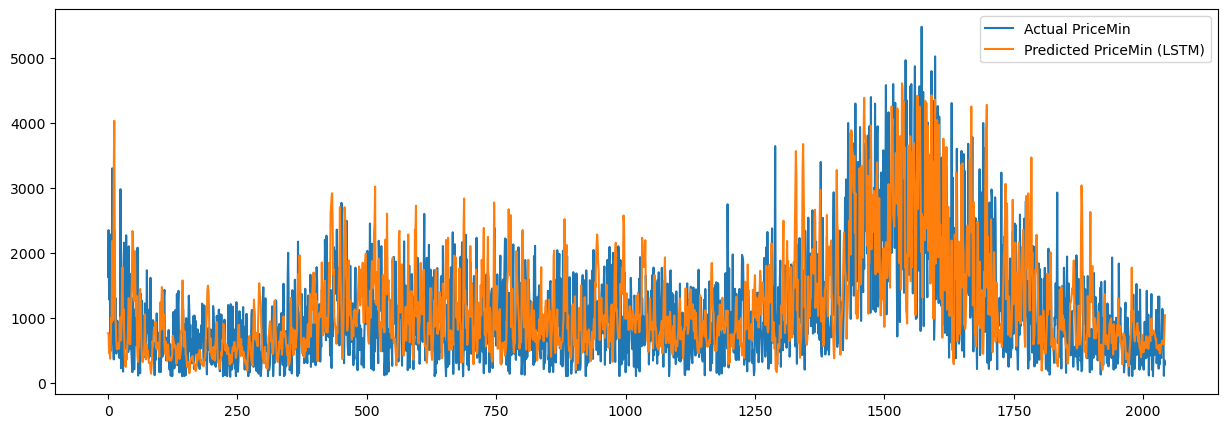

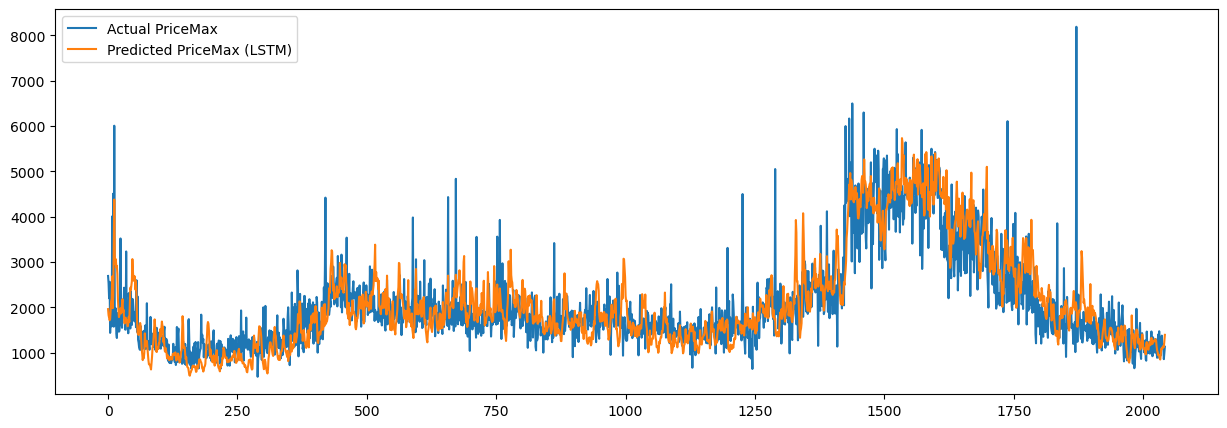

In [5]:


# Build the optimized LSTM model
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(time_step, X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(50))
model.add(Dense(3))  # 1 for quantity and 2 for prices

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the model
model.fit(X_train, np.concatenate((y_quantity_train.reshape(-1, 1), y_prices_train), axis=1), batch_size=32, epochs=50)

# Make predictions
predictions = model.predict(X_test)

# Inverse transform the predictions
predicted_quantity = scaler.inverse_transform(np.concatenate((np.zeros((predictions.shape[0], 1)), predictions[:, 0].reshape(-1, 1), np.zeros((predictions.shape[0], scaled_data.shape[1] - 2))), axis=1))[:, 1]
predicted_prices = scaler.inverse_transform(np.concatenate((np.zeros((predictions.shape[0], 2)), predictions[:, 1:], np.zeros((predictions.shape[0], scaled_data.shape[1] - 4))), axis=1))[:, 2:4]

# Calculate metrics for LSTM
lstm_metrics_quantity = calculate_metrics(actual_quantity, predicted_quantity)
lstm_metrics_priceMin = calculate_metrics(actual_prices[:, 0], predicted_prices[:, 0])
lstm_metrics_priceMax = calculate_metrics(actual_prices[:, 1], predicted_prices[:, 1])

# Print the metrics
print('LSTM Quantity Metrics: MSE: {:.3f}, MAE: {:.3f}, RMSE: {:.3f}'.format(*lstm_metrics_quantity))
print('LSTM PriceMin Metrics: MSE: {:.3f}, MAE: {:.3f}, RMSE: {:.3f}'.format(*lstm_metrics_priceMin))
print('LSTM PriceMax Metrics: MSE: {:.3f}, MAE: {:.3f}, RMSE: {:.3f}'.format(*lstm_metrics_priceMax))

# Plot LSTM predictions vs actual
plt.figure(figsize=(15, 5))
plt.plot(actual_quantity, label='Actual Quantity')
plt.plot(predicted_quantity, label='Predicted Quantity (LSTM)')
plt.legend()
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(actual_prices[:, 0], label='Actual PriceMin')
plt.plot(predicted_prices[:, 0], label='Predicted PriceMin (LSTM)')
plt.legend()
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(actual_prices[:, 1], label='Actual PriceMax')
plt.plot(predicted_prices[:, 1], label='Predicted PriceMax (LSTM)')
plt.legend()
plt.show()
